In [ ]:
!pip install fidle
import fidle
import h5py
import os
import numpy as np
from hashlib import blake2b
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00


In [ ]:
class MNIST():

    version = '0.1'

    def __init__(self):
        pass
    def get_origine(scale=1, normalize=True, expand=True, concatenate=True):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        print('Dataset loaded.')

        # ---- Normalization
        if normalize:
            x_train = x_train.astype('float32') / 255.
            x_test  = x_test.astype( 'float32') / 255.
            print('Normalized.')
        if expand:
            x_train = np.expand_dims(x_train, axis=-1)
            x_test  = np.expand_dims(x_test,  axis=-1)
            print('Reshaped.')

        # ---- scale
        n1 = int(len(x_train)*scale)
        n2 = int(len(x_test)*scale)
        x_train = x_train[:n1]
        y_train = y_train[:n1]
        x_test  = x_test[:n2]
        y_test  = y_test[:n2]

        # ---- Concatenate
        if concatenate:
            x_data = np.concatenate([x_train, x_test], axis=0)
            y_data = np.concatenate([y_train, y_test])
            print('Concatenate.')
            print('x shape :', x_data.shape)
            print('y shape :', y_data.shape)
            return x_data,y_data
        else:
            print('x_train shape :', x_train.shape)
            print('y_train shape :', y_train.shape)
            print('x_test  shape :', x_test.shape)
            print('y_test  shape :', y_test.shape)
            return x_train,y_train,x_test,y_test

    def save_prepared_dataset(clean_data, noisy_data, class_data, filename='./data/mnist-noisy.h5'):
        path=os.path.dirname(filename)
        os.makedirs(path, mode=0o750, exist_ok=True)

        with h5py.File(filename, "w") as f:
            f.create_dataset("clean_data", data=clean_data)
            f.create_dataset("noisy_data", data=noisy_data)
            f.create_dataset("class_data", data=class_data)
        print('Saved.')
        print('clean_data shape is : ',clean_data.shape)
        print('noisy_data shape is : ',noisy_data.shape)
        print('class_data shape is : ',class_data.shape)

    def reload_prepared_dataset(scale=1., train_prop=0.8, shuffle=True, seed=False, filename='./data/mnist-noisy.h5'):

        # ---- Load saved dataset
        #
        with  h5py.File(filename,'r') as f:
            clean_data  = f['clean_data'][:]
            noisy_data  = f['noisy_data'][:]
            class_data  = f['class_data'][:]
        print('Loaded.')

        # ---- Rescale
        #
        n = int(scale*len(clean_data))
        clean_data, noisy_data, class_data = clean_data[:n], noisy_data[:n], class_data[:n]
        print(f'rescaled ({scale}).')

        # ---- Seed
        #
        if seed is not False:
            np.random.seed(seed)
            print(f'Seeded ({seed})')

        # ---- Shuffle
        #
        if shuffle:
            p = np.random.permutation(len(clean_data))
            clean_data, noisy_data, class_data = clean_data[p], noisy_data[p], class_data[p]
            print('Shuffled.')

        # ---- Split
        #
        n=int(len(clean_data)*train_prop)
        clean_train, clean_test = clean_data[:n], clean_data[n:]
        noisy_train, noisy_test = noisy_data[:n], noisy_data[n:]
        class_train, class_test = class_data[:n], class_data[n:]
        print(f'splited ({train_prop}).')

        # ---- Hash
        #
        h = blake2b(digest_size=10)
        for a in [clean_train,clean_test, noisy_train,noisy_test, class_train,class_test]:
            h.update(a)

        print('clean_train shape is : ', clean_train.shape)
        print('clean_test  shape is : ', clean_test.shape)
        print('noisy_train shape is : ', noisy_train.shape)
        print('noisy_test  shape is : ', noisy_test.shape)
        print('class_train shape is : ', class_train.shape)
        print('class_test  shape is : ', class_test.shape)
        print('Blake2b digest is    : ', h.hexdigest())
        return  clean_train,clean_test, noisy_train,noisy_test, class_train,class_test

In [ ]:
clean_data, class_data = MNIST.get_origine(scale=1)

11490434/11490434 [==============================] - 0s 0us/step
Dataset loaded.
Normalized.
Reshaped.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)


#Add Noisiness to clean data

In [ ]:
from skimage import io
from skimage.util import random_noise

def noise_it(data):
    new_data = np.copy(data)
    for i,image in enumerate(new_data):
        fidle.utils.update_progress('Add noise : ',i+1,len(data))
        image=random_noise(image, mode='gaussian', mean=0, var=0.3)
        image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        image=random_noise(image, mode='poisson')
        image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        new_data[i]=image
    print('Done.')
    return new_data

# ---- Add noise to input data : x_data
noisy_data = noise_it(clean_data)

Add noise :      [########################################] 100.0% of 70000
Done.


#Clean data VS Noisy data

Clean dataset (clean_data) :  (70000, 28, 28, 1)
Noisy dataset (noisy_data) :  (70000, 28, 28, 1)


<br>**Noisy images we'll have in input (or x)**

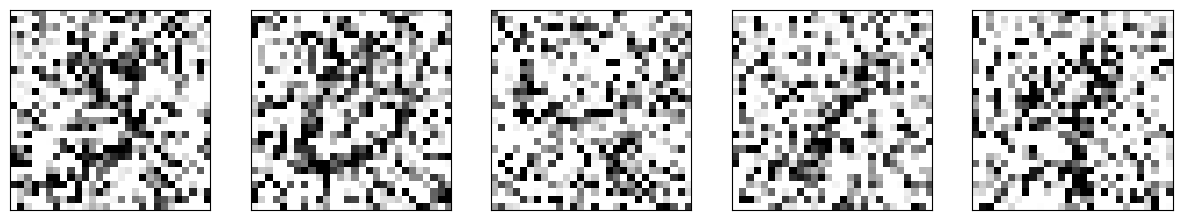

<br>**Clean images we want to obtain (or y)**

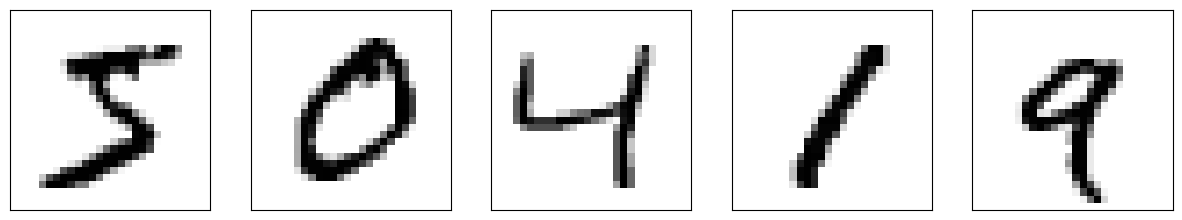

In [ ]:
print('Clean dataset (clean_data) : ',clean_data.shape)
print('Noisy dataset (noisy_data) : ',noisy_data.shape)

fidle.utils.subtitle("Noisy images we'll have in input (or x)")
fidle.scrawler.images(noisy_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='01-noisy')
fidle.utils.subtitle('Clean images we want to obtain (or y)')
fidle.scrawler.images(clean_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='02-original')

In [ ]:
p = np.random.permutation(len(clean_data))
clean_data, noisy_data, class_data = clean_data[p], noisy_data[p], class_data[p]
print('Shuffled.')

Shuffled.


In [ ]:
prepared_dataset = './data/mnist-noisy.h5'
MNIST.save_prepared_dataset( clean_data, noisy_data,class_data, filename=prepared_dataset )

Saved.
clean_data shape is :  (70000, 28, 28, 1)
noisy_data shape is :  (70000, 28, 28, 1)
class_data shape is :  (70000,)


In [ ]:
prepared_dataset = './data/mnist-noisy.h5'
dataset_seed     = 123

scale            = 1

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 30
fit_verbosity    = 1

#Splitting Data

In [ ]:
clean_train,clean_test, noisy_train,noisy_test, class_train,class_test = MNIST.reload_prepared_dataset(
                                                                                    scale      = scale,
                                                                                    train_prop = train_prop,
                                                                                    seed       = dataset_seed,
                                                                                    shuffle    = True,
                                                                                    filename   = prepared_dataset)

Loaded.
rescaled (1).
Seeded (123)
Shuffled.
splited (0.8).
clean_train shape is :  (56000, 28, 28, 1)
clean_test  shape is :  (14000, 28, 28, 1)
noisy_train shape is :  (56000, 28, 28, 1)
noisy_test  shape is :  (14000, 28, 28, 1)
class_train shape is :  (56000,)
class_test  shape is :  (14000,)
Blake2b digest is    :  2169fff2af0e1a7a0cf7


#Encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 flatten_6 (Flatten)         (None, 3136)              0         
                                                                 
 dense_10 (Dense)            (None, 16)                50192     
                                                                 
 dense_11 (Dense)            (None, 10)                170       
                                                                 
Total params: 69178 (270.23 KB)
Trainable params: 69178 (27

#Decoder

In [ ]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_12 (Dense)            (None, 3136)              34496     
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 28, 28, 1)         289 

#CAE

In [ ]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name='ae')

#CNN1

In [ ]:
inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(8, (3,3),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(100, activation='relu')(x)
outputs   = keras.layers.Dropout(0.5)(x)

cnn1       = keras.Model(inputs, outputs, name='cnn1')

#CNN2

In [ ]:
inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(32, (5,5),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Conv2D(64, (5,5), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(50, activation='relu')(x)
outputs   = keras.layers.Dropout(0.3)(x)

cnn2       = keras.Model(inputs, outputs, name='cnn2')

#Final CNN (CNN1 Mixed with CNN2)

In [ ]:
inputs    = keras.Input(shape=(28, 28, 1))

denoised = ae(inputs)

branch_1 = cnn1(inputs)
branch_2 = cnn2(inputs)

x        = keras.layers.concatenate([branch_1,branch_2], axis=1)

classcat = keras.layers.Dense(10, activation='softmax', name='cnn')(x)


model = keras.Model(inputs, [denoised, classcat])

model.compile(optimizer='rmsprop',
              loss={'ae':'binary_crossentropy', 'cnn':'sparse_categorical_crossentropy'},
              loss_weights=[1,1],
              metrics={'cnn':'accuracy'} )

#Training the model

In [ ]:
chrono = fidle.Chrono()
chrono.start()

history = model.fit(noisy_train, [clean_train, class_train],
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noisy_test, [clean_test, class_test]))

chrono.show()

Epoch 1/30
438/438 [==============================] - 21s 19ms/step - loss: 1.3688 - ae_loss: 0.2773 - cnn_loss: 1.0915 - cnn_accuracy: 0.6282 - val_loss: 0.7706 - val_ae_loss: 0.2195 - val_cnn_loss: 0.5512 - val_cnn_accuracy: 0.8296
Epoch 2/30
  6/438 [..............................] - ETA: 4s - loss: 0.8791 - ae_loss: 0.2187 - cnn_loss: 0.6604 - cnn_accuracy: 0.7786

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 6s 14ms/step - loss: 0.7983 - ae_loss: 0.1961 - cnn_loss: 0.6022 - cnn_accuracy: 0.8040 - val_loss: 0.6205 - val_ae_loss: 0.1818 - val_cnn_loss: 0.4386 - val_cnn_accuracy: 0.8626
Epoch 3/30
438/438 [==============================] - 6s 15ms/step - loss: 0.6905 - ae_loss: 0.1734 - cnn_loss: 0.5171 - cnn_accuracy: 0.8315 - val_loss: 0.5699 - val_ae_loss: 0.1723 - val_cnn_loss: 0.3975 - val_cnn_accuracy: 0.8747
Epoch 4/30
438/438 [==============================] - 6s 14ms/step - loss: 0.6412 - ae_loss: 0.1658 - cnn_loss: 0.4754 - cnn_accuracy: 0.8447 - val_loss: 0.5231 - val_ae_loss: 0.1647 - val_cnn_loss: 0.3584 - val_cnn_accuracy: 0.8855
Epoch 5/30
438/438 [==============================] - 6s 14ms/step - loss: 0.6045 - ae_loss: 0.1613 - cnn_loss: 0.4432 - cnn_accuracy: 0.8557 - val_loss: 0.5008 - val_ae_loss: 0.1588 - val_cnn_loss: 0.3420 - val_cnn_accuracy: 0.8902
Epoch 6/30
438/438 [==============================] - 6s 14ms/step - loss: 0.58

#Metrics Plots during training

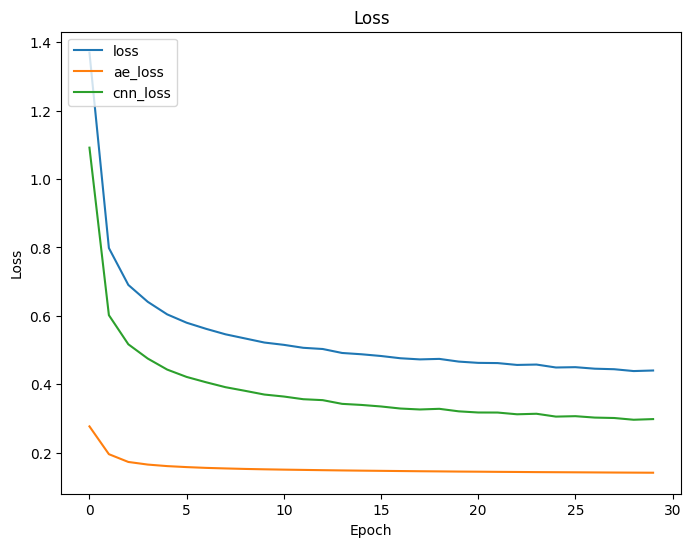

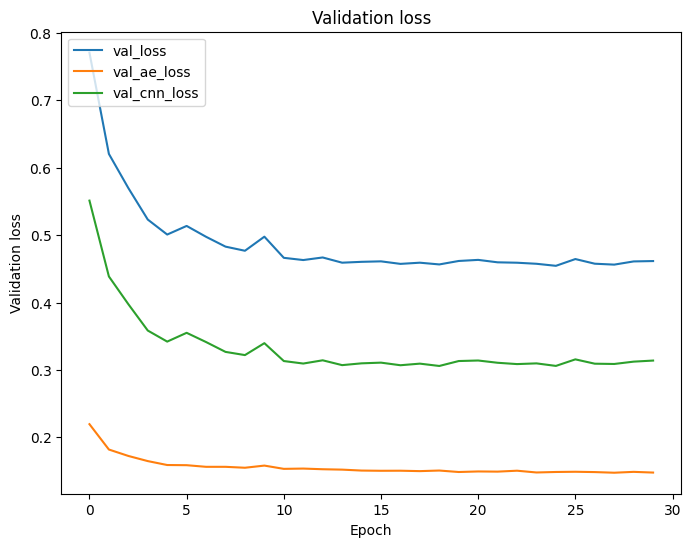

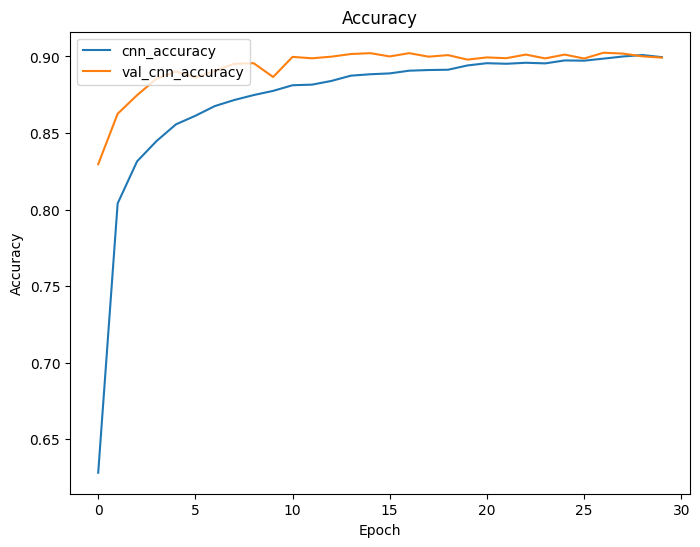

In [ ]:
fidle.scrawler.history(history,  plot={'Loss':['loss', 'ae_loss', 'cnn_loss'],
                                 'Validation loss':['val_loss','val_ae_loss', 'val_cnn_loss'],
                                 'Accuracy':['cnn_accuracy','val_cnn_accuracy']}, save_as='01-history')

#Denoising Progress

<br>**Real images (clean_test) :**

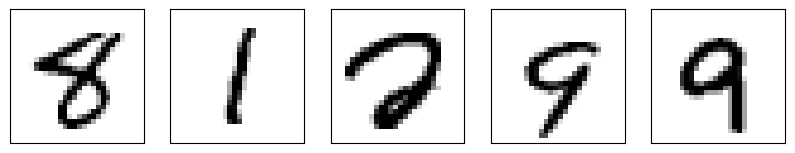

<br>**Noisy images (noisy_test) :**

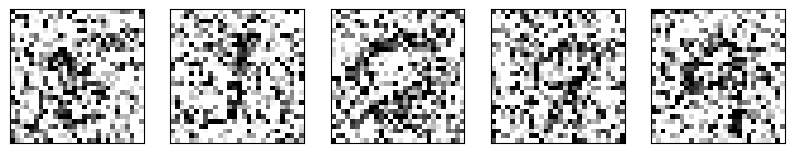

<br>**Evolution during the training period (denoised_test) :**

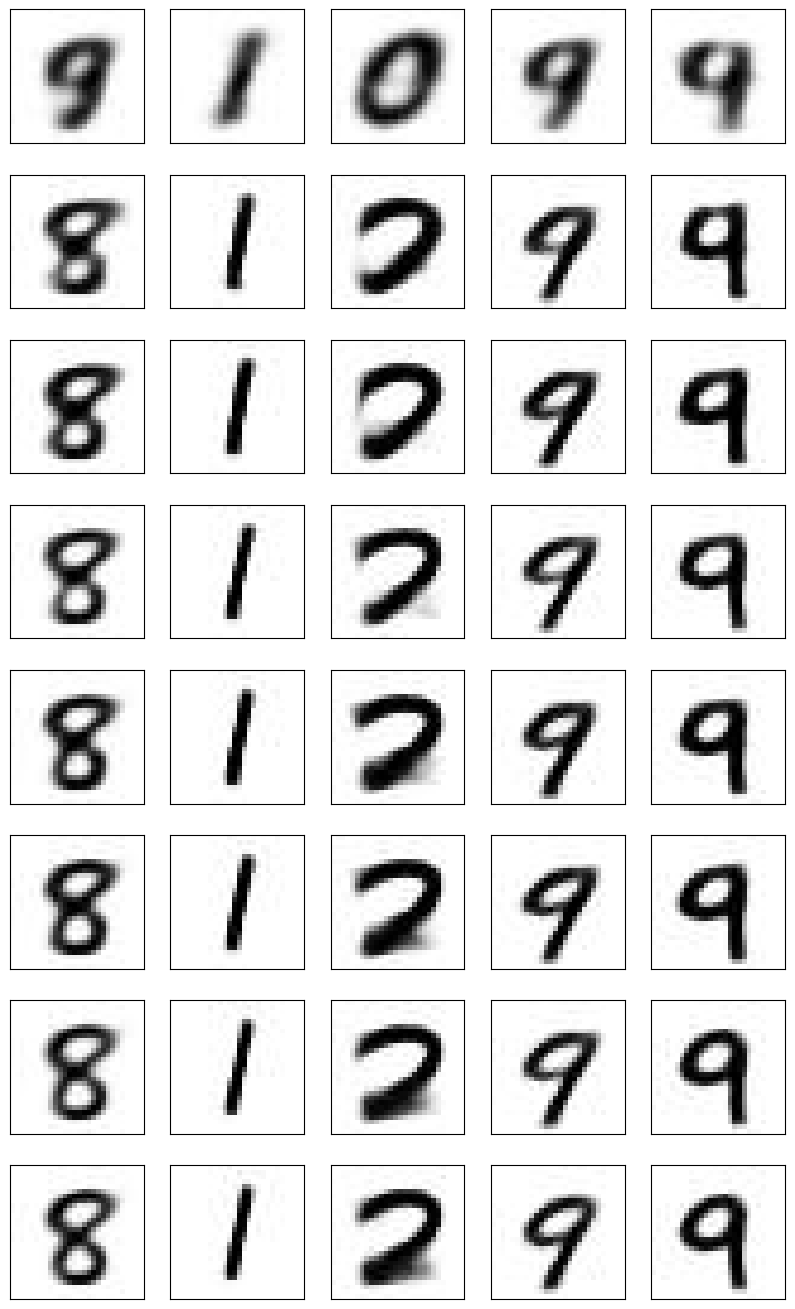

<br>**Noisy images (noisy_test) :**

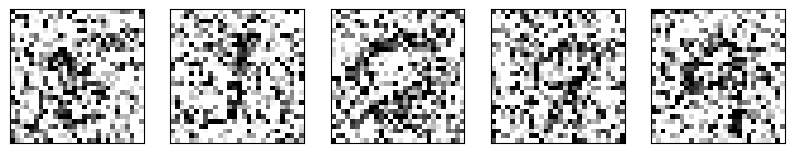

<br>**Real images (clean_test) :**

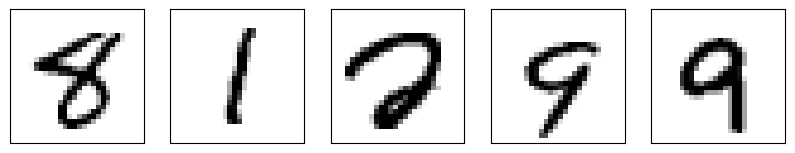

In [ ]:
imgs=[]
for epoch in range(0,epochs,4):
    for i in range(5):
        filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)

fidle.utils.subtitle('Real images (clean_test) :')
fidle.scrawler.images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='02-original-real')

fidle.utils.subtitle('Noisy images (noisy_test) :')
fidle.scrawler.images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='03-original-noisy')

fidle.utils.subtitle('Evolution during the training period (denoised_test) :')
fidle.scrawler.images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, y_padding=0.1, save_as='04-learning')

fidle.utils.subtitle('Noisy images (noisy_test) :')
fidle.scrawler.images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

fidle.utils.subtitle('Real images (clean_test) :')
fidle.scrawler.images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

#Evaluation

In [ ]:
denoised_test, classcat_test = history.predict(noisy_test, verbose=0)

print('Denoised images   (denoised_test) shape : ',denoised_test.shape)
print('Predicted classes (classcat_test) shape : ',classcat_test.shape)

Denoised images   (denoised_test) shape :  (14000, 28, 28, 1)
Predicted classes (classcat_test) shape :  (14000, 10)


<br>**Noisy test images (input):**

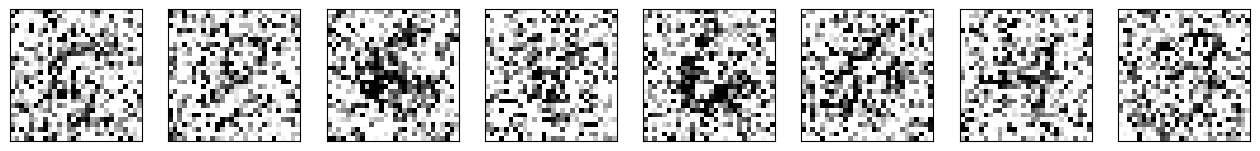

<br>**Denoised images (output):**

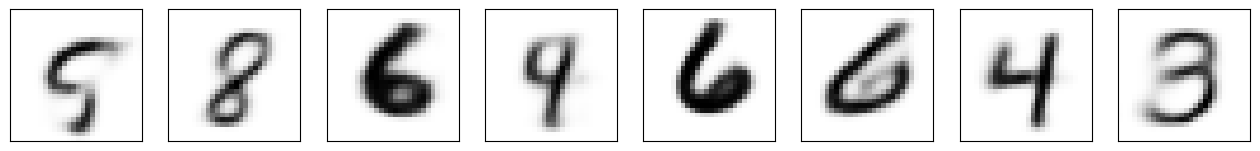

<br>**Real test images :**

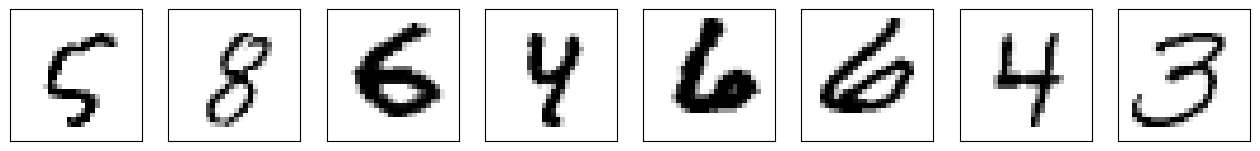

In [ ]:
import random
i=random.randint(0,len(denoised_test)-8)
j=i+8

fidle.utils.subtitle('Noisy test images (input):')
fidle.scrawler.images(noisy_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='05-test-noisy')

fidle.utils.subtitle('Denoised images (output):')
fidle.scrawler.images(denoised_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='06-test-predict')

fidle.utils.subtitle('Real test images :')
fidle.scrawler.images(clean_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='07-test-real')

#ACCURACY

<br>**Accuracy :**

Classification accuracy : 0.9012


<br>**Few examples :**

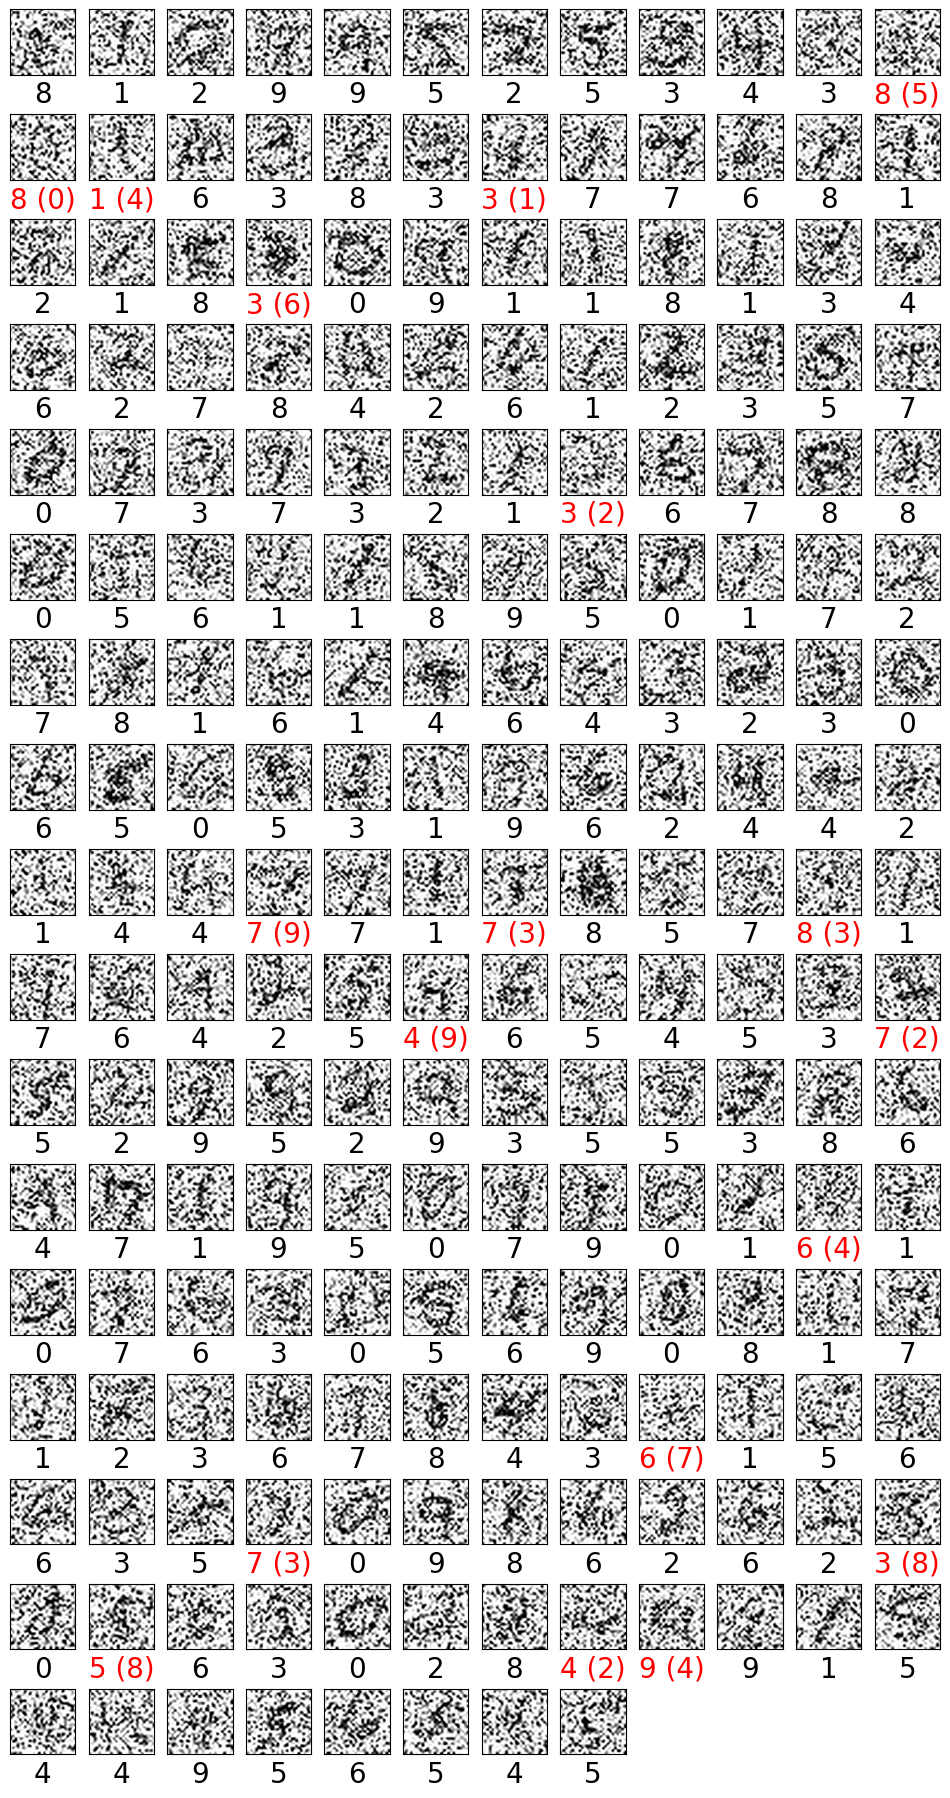

In [ ]:
score = model.evaluate(noisy_test, [clean_test, class_test], verbose=0)

fidle.utils.subtitle("Accuracy :")
print(f'Classification accuracy : {score[3]:4.4f}')

fidle.utils.subtitle("Few examples :")
classid_test  = np.argmax(classcat_test, axis=-1)
fidle.scrawler.images(noisy_test, class_test, range(0,200), columns=12, x_size=1, y_size=1, y_pred=classid_test, save_as='04-predictions')